# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.521926,True,4.168561
1,0.529100,True,7.446772
2,-1.185175,True,4.837306
3,-0.536551,False,0.929058
4,0.727100,True,3.123939
...,...,...,...
995,-2.869465,False,-1.675050
996,-2.160877,False,-0.659050
997,-2.016886,False,1.137603
998,-2.459570,False,-0.274213


<AxesSubplot: xlabel='v0'>

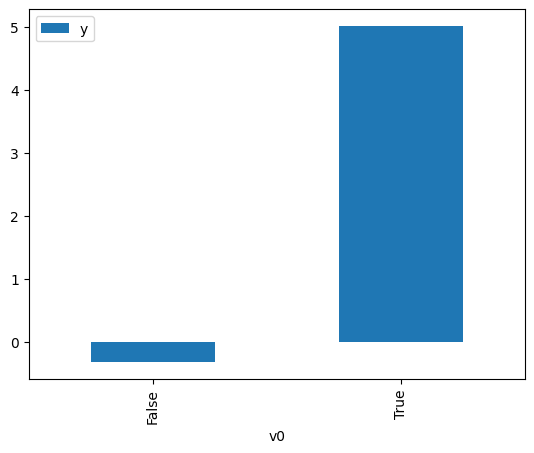

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

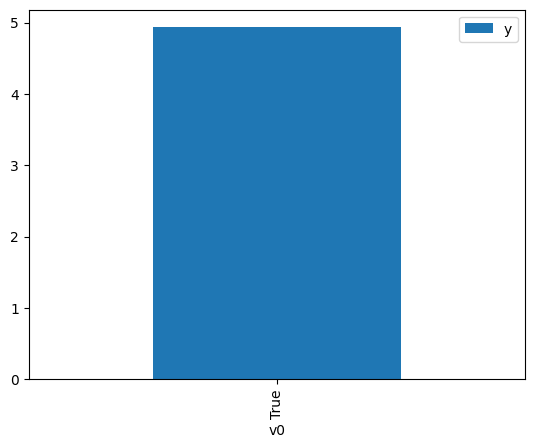

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.463625,False,-0.166308,0.875040,1.142805
1,-1.621213,False,-0.373634,0.896014,1.116054
2,-1.374278,False,0.052919,0.861603,1.160628
3,-1.047494,False,-0.434254,0.801950,1.246960
4,0.292719,False,-1.056471,0.409613,2.441328
...,...,...,...,...,...
995,-3.454525,False,-2.009146,0.989716,1.010391
996,0.428610,False,-0.380013,0.367156,2.723637
997,-0.638404,False,-0.199366,0.702672,1.423140
998,-1.139601,False,-0.450883,0.820504,1.218763


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.019015,True,4.490301,0.488811,2.045780
1,-1.734372,True,4.151437,0.090904,11.000660
2,-1.452795,True,4.504987,0.126527,7.903423
3,-0.715856,True,5.437658,0.276478,3.616923
4,-1.456313,True,6.062515,0.126017,7.935462
...,...,...,...,...,...
995,0.315108,True,5.332239,0.597494,1.673656
996,-1.928974,True,5.135653,0.071837,13.920323
997,-1.452795,True,4.504987,0.126527,7.903423
998,-0.076314,True,2.974456,0.469990,2.127705


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.883
Model:                            OLS   Adj. R-squared (uncentered):              0.882
Method:                 Least Squares   F-statistic:                              3755.
Date:                Wed, 16 Nov 2022   Prob (F-statistic):                        0.00
Time:                        12:08:46   Log-Likelihood:                         -1433.7
No. Observations:                1000   AIC:                                      2871.
Df Residuals:                     998   BIC:                                      2881.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3593      0.024     14.807      0.000       0.312       0.407
x2             5.1146      0.059     86.157      0.000       4.998       5.231
==============================================================================
Omnibus:                        0.692   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.707   Jarque-Bera (JB):                0.564
Skew:                          -0.001   Prob(JB):                        0.754
Kurtosis:                       3.116   Cond. No.                         2.45
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""